# Data Analysis - Semantic vs. Syntactic dependecies

In [131]:
import sys, os, json
from collections import defaultdict, Counter
from importlib import reload
from IPython.display import HTML, display
import tabulate
import matplotlib.pyplot as plt
from typing import List, Any, Dict, Tuple, Callable, Iterable, Union
from graph import Graph     # mtool graphs
import networkx as nx, numpy as np
from networkx import NetworkXNoPath

# root of project in nlp-architext repo
libert_dir = "/data/home/ayalklei/nlp-architect/nlp_architect/models/libert"
analysis_dir = f"{libert_dir}/analysis"

# useful "meta" data - number of sentence per domain 
# (can be computed by #-lines in raw_sentences.txt files - `wc $liber_dir/analysis/raw_sentences/*.txt`)
num_sents = {"device": 3834, "restaurants": 5842, "laptops": 3846}
domains = list(num_sents.keys())

# usefull general utils
def display_table(table):
    display(HTML(tabulate.tabulate(table, tablefmt='html')))

def display_ndict(nested_dict: Dict[str, Dict[str, Any]], with_mean=True, pprint: Callable = None):
    """ Display two-level nested dict as a pretty table. """
    if not pprint:
        pprint = lambda x:x
    row_labels = list(nested_dict.keys())
    column_labels = list(list(nested_dict.values())[0].keys())
    as_tabular = [["-"] + column_labels] + \
                 [[row] + [pprint(nested_dict[row][col]) for col in column_labels]
                  for row in row_labels]
    if with_mean:
        as_tabular[0] += ["mean"]
        for i in range(1, len(as_tabular)):
            mean = np.mean(as_tabular[i][1:])
            as_tabular[i] += [mean]
    display_table(as_tabular)

def display_absa_graph(graph: Graph, method="displacy"):
    # visualize
    print(f"Sentence: {graph.input}")
    if method == "dot":
        # visalize using dot
        dot_fn = "dot_example.dot"
        graph.dot(open(dot_fn, "w"))    # write dot file
        # see dot in jupyter
        def view_dot(fn):
            from graphviz import Source
            return Source.from_file(fn)
        return view_dot(dot_fn)
    elif method=="tikz":
        # visalize using tikz
        tikz_fn = "tikz_example.tex"
        graph.tikz(open(tikz_fn, "w"))    # write tikz latex file
        # I can't show it in notebook meantime since %load_ext tikzmagic not working
        return None
    else:
        print("opinions: ", graph.opinion_spans, 
              [' '.join(graph.input.split(" ")[i] 
                        for span in graph.opinion_spans 
                        for i in range(*span))])
        print("aspects: ", graph.aspect_spans,
              [' '.join(graph.input.split(" ")[i] 
                        for span in graph.aspect_spans 
                        for i in range(*span))])
        graph.displacy(jupyter=True, options={"compact":True, "distance":100})
            
def plot_hist_with_long_labels(array, bins=None, title=""):
    """ Display hostogram with rotated x-labels """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.hist(array, bins = bins or len(array), color = 'blue', edgecolor = 'black',)
    for tick in ax.get_xticklabels():
        tick.set_rotation(270)
    ax.set_title(title)

def plot_bar_with_long_labels(labels, values, title=""):
    """ Display hostogram with rotated x-labels """
    import matplotlib.pyplot as plt
    indexes = np.arange(len(labels))
    fig, ax = plt.subplots()
    ax.bar(indexes, values, color = 'blue', edgecolor = 'black')
    for tick in ax.get_xticklabels():
        tick.set_rotation(270)
    plt.xticks(indexes, labels)
    ax.set_title(title)

def plot_counter_with_long_labels(c: Counter):
    plot_bar_with_long_labels(*zip(*c.items()))

In [93]:
# utils for loading and visualizing dependency graphs (both syntactic and semantic) 
def load_parsed_graph(formalism="dm", domain="restaurants", graph_id = 1) -> Graph:
    # load a parsed graph
    if formalism is "clir":
        parsed_graphs_dir=f"{libert_dir}/analysis/spacy-syndep-parses"
        parsed_fn=f"{parsed_graphs_dir}/{domain}-syndep.mrp"
    elif formalism is "ud":
        parsed_graphs_dir=f"{libert_dir}/analysis/udpipe-syndep-parses"
        parsed_fn=f"{parsed_graphs_dir}/{domain}-syndep.mrp"
    elif formalism in ["dm", "psd"]:    
        parsed_graphs_dir=f"{libert_dir}/analysis/HIT-SCIR-parses"
        parsed_fn=f"{parsed_graphs_dir}/{formalism}-{domain}-output.mrp"
    else:
        raise ValueError(f"formalism {formalism} is not among supprted formalisms - clir (spacy), ud, dm, psd")

    with open(parsed_fn) as fin:
        lines = list(fin.readlines())
    g = Graph.decode(json.loads(lines[graph_id]))
    # fix nodes in parsed_graph to include all tokens in input sentence
    g._full_sentence_recovery() # my own addition to mtool, not yet merged into `master`
    return g


# running example
g = load_parsed_graph("ud")
print([n.label for n in g.nodes], len(g.nodes))


['To', 'be', 'completely', 'fair', ',', 'the', 'only', 'redeeming', 'factor', 'was', 'the', 'food', ',', 'which', 'was', 'above', 'average', ',', 'but', 'could', "n't", 'make', 'up', 'for', 'all', 'the', 'other', 'deficiencies', 'of', 'Teodora', '.'] 31


## Loading ABSA information into graphs
Mark nodes in the graph with 'opinion' and 'aspect' boolean attributes  

In [94]:
# first, read ABSA data from "conll" BIO-tagged files into a intermediate format.
# our format will be per sentence - {"sentence_id":..., "tokens": [...], "token_tags": [...], 
#                                       "aspect_spans": [(from_id, to_id), ...],
#                                       "opinion_spans": [(from_id, to_id), ...]}
absa_data_dir = f"{libert_dir}/data/conll/domains_all"
absa_data = {}
formalisms = ["clir", "ud", "dm", "psd"]
for domain in domains:
    absa_bio_fn = f"{absa_data_dir}/{domain}.txt"
    with open(absa_bio_fn) as fin:
        # read blocks, and in empty lines (=block delimiter) - consolidate block (=sentence) info
        block_tuples = []   # a tuple correspond to a line; 
                            # in these conll-bio ABSA files, it is a (token, bio_tag) pair
        bio_spans, cur_span_info = [], None
        data = []
        running_sentence_id = 0
        token_id = 0
        for line in fin:
            line = line.strip()
            if line != "":
                block_tuples.append(line.split())
                # on the same pass, collect BIO spans info
                _, bio_tag = line.split()
                if (bio_tag == "O" or bio_tag.startswith("B")) and cur_span_info: 
                    # finalize previous span
                    cur_span_info["to"] = token_id  # span is exclusive
                    bio_spans.append(cur_span_info)
                    cur_span_info = None
                if bio_tag.startswith("B"): # start new span 
                    # start new span 
                    label = bio_tag.split("-")[1]
                    cur_span_info = {"from": token_id, "label": label}
                token_id += 1
            else:   # line seperator, consolidate block information
                tokens, bio_tags = zip(*block_tuples)
                # ABSA-specific logic:
                # split bio_spans into aspect spans and opinion spans 
                apsect_spans = [(s["from"], s["to"]) for s in bio_spans if s["label"]=="ASP"]
                opinion_spans = [(s["from"], s["to"]) for s in bio_spans if s["label"]=="OP"]

                sentence_data = {"sentence_id": f"{running_sentence_id:04}",
                                 "tokens": list(tokens),
                                 "token_tags": bio_tags,    # auxilary info
                                 "apsect_spans": apsect_spans,
                                 "opinion_spans": opinion_spans}
                data.append(sentence_data) 
                # initialize for next block   
                running_sentence_id += 1
                block_tuples = [] 
                token_id = 0
                bio_spans, cur_span_info = [], None
    absa_data[domain] = data

In [117]:
# now with any loaded graph, we can augment ABSA information into graph
def load_absa_graph(formalism="dm", domain="laptops", graph_id = 3240):
    g = load_parsed_graph(formalism=formalism, domain=domain, graph_id=graph_id)
    sent_absa = absa_data[domain][graph_id]
    # verify correspondense
    assert g.input.split() == sent_absa["tokens"], \
        f"mismatch between parsed graph and absa-data: '{g.input.split()}' vs. '{sent_absa['tokens']}'"
    # augment ABSA info into graphs:
    #  - in graph level (`aspect_spans` and `opinion_spans` graph properties)
            # `first_node` requisite: fixing node ids in "aspect/opinion terms" so that they will correspond 
            # to their index in g.nodes list. It is mainly for 1-indexed graphs like
            # those deserialized from CoNLL-U files (where first token's id is 1 and not 0).
    first_node = min(n.id for n in g.nodes)
    g.aspect_spans = [(b+first_node,e+first_node) for b,e in sent_absa["apsect_spans"]]
    g.opinion_spans = [(b+first_node,e+first_node) for b,e in sent_absa["opinion_spans"]]
    #  - in node level (`aspect_term` and `opinion_term` node properties)
    for n in g.nodes:
        n.aspect_term = False
        n.opinion_term = False
    for span in g.aspect_spans:
        for i in range(*span):
            g.find_node(i).aspect_term = True
    for span in g.opinion_spans:
        for i in range(*span):
            g.find_node(i).opinion_term = True
    return g

# Select running example 
formalism="ud"; domain="device"; graph_id=num_sents[domain]
g = load_parsed_graph(formalism=formalism, domain=domain, graph_id=graph_id)
g2 = load_absa_graph(formalism=formalism, domain=domain, graph_id=graph_id)
# g2.displacy(jupyter=True)
# absa_data["laptops"][3034]


In [96]:
# inspect some properties of example graph
print('  '.join([f"{i}:{tok}" for i,tok in enumerate(g2.input.split())]))
print("aspects:", g2.aspect_spans)
print("opinions:", g2.opinion_spans)

0:feels  1:solid  2:in  3:hand  4:.
aspects: [(1, 2)]
opinions: [(2, 3)]


## Collect & Filter indicative graphs
Filter sentences with single OT & single AT. Since we don't have a AT<->OT mapping in the annotations, we should limit the analysis of AT--OT paths to cases where we are certain they are corresponding.   

In [97]:
# collect all graphs (by formalism, by domain) - NOTE: takes several minutes in first run, afterwards loading from file
from collections import defaultdict
import pickle
all_graphs_fn = "all_absa_graphs.pickle"
try:
    all_graphs = pickle.load(open(all_graphs_fn, "rb"))
except FileNotFoundError:
    all_graphs = defaultdict(dict)  # will be: {<formalism>: {<domain>: [sent-0-graph, ...], ...}, ...}
    for formalism in formalisms:
        for domain in domains:
            graphs = [load_absa_graph(formalism, domain, i) for i in range(num_sents[domain])]
            all_graphs[formalism][domain] = graphs
    pickle.dump(all_graphs, open(all_graphs_fn, "wb"))

In [98]:
def count_graphs(graphs: Dict[str, Dict[str, List[Graph]]]) -> int:
    return  sum([1
                 for formalism_dict in graphs.values()
                 for domain_list in formalism_dict.values()
                 for g in domain_list])
print(f"collected {count_graphs(all_graphs)} graphs.")

collected 54088 graphs.


In [99]:
# filter indicative graphs 
def is_indicative_graph(g: Graph) -> bool:
    """ return true iff sentence have a single Aspect-Term (AT) and a single Opinion-Term (OT). """
    return len(g.aspect_spans)==1 and len(g.opinion_spans)==1

indicative_sentences_ids = {domain: [i
                                     for i in range(num_sents[domain]) 
                                     if is_indicative_graph(all_graphs["ud"][domain][i])]
                            for domain in domains}
all_indicative_graphs = {formalism: 
                             {domain: 
                                  [all_graphs[formalism][domain][i]
                                   for i in range(num_sents[domain])
                                   if i in indicative_sentences_ids[domain]]
                              for domain in domains}
                         for formalism in formalisms}


In [100]:
print(f"collected {count_graphs(all_indicative_graphs)} indicative graphs.")

collected 9804 indicative graphs.


## Leveraging NetworkX classes for data analysis
We will convert mtool's `Graph`s to `nx.DiGraph` objects. 
Then, we can use nx to search for path and to convert the graph to an undirected graph. 


In [165]:
def take_keys(d: Dict, keys: List[Any]):
    return {k:v for k,v in d.items() if k in keys}

def to_nx(g: Graph) -> nx.DiGraph:
    graph_attr = take_keys(g.__dict__, ["flavor", "framework", "id", "input", "opinion_spans", "aspect_spans"])
    nxg = nx.DiGraph(**graph_attr)
    nxg.g = g # save original `mtool` Graph object simple as `g` property
    # for better transparency between nx.DiGraph and mtool's Graph, put graph attributes
    # as first order properties in DiGraph object
    nxg.__dict__.update(**graph_attr)
    # add nodes
    for node in g.nodes:
        attr = take_keys(node.__dict__, ['id', 'anchors', 'label', 'is_top', 'type', 'opinion_term', 'aspect_term'])
        # put g.node properties as first-order citizens in nxg.node properties
        if node.properties and node.values:
            attr.update(dict(zip(node.properties, node.values)))
        nxg.add_node(node.id, **attr)
    # add edges
    for edge in g.edges:
        attr = take_keys(edge.__dict__, ['lab', 'anchors', 'id', 'normal'])
        # put g.edge attributes as first-order citizens in nxg.edge properties
        if edge.attributes and edge.values:
            attr.update(dict(zip(edge.attributes, edge.values)))
        nxg.add_edge(edge.src, edge.tgt, **attr)
    return nxg

# running example
g2 = all_indicative_graphs["ud"]["device"][0]
nxg = to_nx(g2)

## Compute average **directed** path length between AT and OT

In [102]:
def filtered(array):
    filtered_array = [e for e in array if e is not None]
    return filtered_array 

def filtered_f(array, f: Callable[[Iterable[Graph],], Any]):
    filtered_array = filtered(array)
    return f(filtered_array) if filtered_array else None

    
def directed_path_length(nxg: nx.DiGraph):
    def shortest_path_length(source, target) -> Union[int, None]:
        try:
            return nx.shortest_path_length(nxg, source=source, target=target)
        except NetworkXNoPath:
            return None
        
    # Return the minimum path length between an OT token and an AT token (either AT~~>OT or OT~~>AT)
    OT2AT_path_lengths = [shortest_path_length(source_tokid, target_tokid) 
                          for source_tokid in range(*nxg.opinion_spans[0])
                          for target_tokid in range(*nxg.aspect_spans[0])]
    AT2OT_path_lengths = [shortest_path_length(source_tokid, target_tokid) 
                          for source_tokid in range(*nxg.aspect_spans[0])
                          for target_tokid in range(*nxg.opinion_spans[0])]
    return filtered_f(OT2AT_path_lengths + AT2OT_path_lengths, min)


In [167]:
# debug example
g2 = all_indicative_graphs["ud"]["device"][0]
nxg = to_nx(g2)
e = list(g2.edges)[0]
# print(g2.input)
# print([n.id for n in g2.nodes])
# print([e for e in nxg.edges])
# directed_path_length(to_nx(g2))
def shortest_path_length(source, target) -> Union[int, None]:
    try:
        return nx.shortest_path_length(nxg, source=source, target=target)
    except NetworkXNoPath:
        return None
n=g2.nodes[14]
print(n.id, n.label, n.opinion_term)
n=nxg.nodes[14]
print(n['id'], n['label'], n['opinion_term'])
print(nxg.opinion_spans)
try:
    print(nx.shortest_path(nxg, source=15, target=13))
except NetworkXNoPath:
    print("no path")
display_absa_graph(g2)

15 delighted True
14 am False
[(15, 16)]
[15, 13]
Sentence: after several years of torture in the hands of at&t customer service i am delighted to drop them , and look forward to august 2004 when i will convert our other 3 family-phones from at&t to t-mobile !
opinions:  [(15, 16)] ['to']
aspects:  [(10, 13)] ['customer service i']


In [104]:
# compute average directed path length per formalism per domain. 
mean_directed_path_length = defaultdict(dict)
count_is_directed_path = defaultdict(dict)
count_indicative_graphs = defaultdict(dict)
for formalism in formalisms:
    for domain in domains:
        shortest_paths = [directed_path_length(to_nx(g)) 
                          for g in all_indicative_graphs[formalism][domain]]
        count_indicative_graphs[formalism][domain] = len(all_indicative_graphs[formalism][domain])
        mean_directed_path_length[formalism][domain] = filtered_f(shortest_paths, np.mean)
        count_is_directed_path[formalism][domain] = filtered_f(shortest_paths, len)

#### Results

In [105]:
# display results in tables
print("#-Graphs for analysis (single AT & single OT):")
display_ndict(count_indicative_graphs)
print("#-Graphs that have a directed path AT~~>OT or OT~~>AT:")
display_ndict(count_is_directed_path)
print("Mean of shortest path length between AT and OT (if exists):")
display_ndict(mean_directed_path_length)


#-Graphs for analysis (single AT & single OT):


-,device,restaurants,laptops,mean
clir,551,1291,609,817.0
ud,551,1291,609,817.0
dm,551,1291,609,817.0
psd,551,1291,609,817.0


#-Graphs that have a directed path AT~~>OT or OT~~>AT:


-,device,restaurants,laptops,mean
clir,225,563,286,358.0
ud,404,1001,461,622.0
dm,392,898,378,556.0
psd,200,558,263,340.3333333333333


Mean of shortest path length between AT and OT (if exists):


-,device,restaurants,laptops,mean
clir,1.3244444444444445,1.355239786856128,1.472027972027972,1.3839040677761816
ud,1.1633663366336633,1.1378621378621379,1.2559652928416485,1.1857312557791497
dm,1.125,1.0846325167037862,1.164021164021164,1.1245512269083167
psd,1.165,1.1881720430107527,1.2357414448669202,1.1963044959592244


## Compute average **undirected** path length between AT and OT

In [106]:
def undirected_path_length(nxg: nx.DiGraph):
    nxug = nxg.to_undirected()
    def shortest_path_length(source, target) -> Union[int, None]:
        try:
            return nx.shortest_path_length(nxug, source=source, target=target)
        except NetworkXNoPath:
            return None
        
    # Return the minimum path length between an OT token and an AT token (AT<~~>OT)
    path_lengths = [shortest_path_length(source_tokid, target_tokid)
                    for source_tokid in range(*nxg.opinion_spans[0])
                    for target_tokid in range(*nxg.aspect_spans[0])]
    return filtered_f(path_lengths, min)

# compute average undirected path length per formalism per domain. 
mean_undirected_path_length = defaultdict(dict)
count_is_undirected_path = defaultdict(dict)
for formalism in formalisms:
    for domain in domains:
        shortest_paths = [undirected_path_length(to_nx(g)) 
                          for g in all_indicative_graphs[formalism][domain]]
        mean_undirected_path_length[formalism][domain] = filtered_f(shortest_paths, np.mean)
        count_is_undirected_path[formalism][domain] = filtered_f(shortest_paths, len)

In [107]:
# display results in tables
print("#-Graphs for analysis (single AT & single OT):")
display_ndict(count_indicative_graphs)
print("#-Graphs that have an undirected path AT<~~>OT:")
display_ndict(count_is_undirected_path)
print("Mean of shortest undirected path length between AT and OT (if exists):")
display_ndict(mean_undirected_path_length)


#-Graphs for analysis (single AT & single OT):


-,device,restaurants,laptops,mean
clir,551,1291,609,817.0
ud,551,1291,609,817.0
dm,551,1291,609,817.0
psd,551,1291,609,817.0


#-Graphs that have an undirected path AT<~~>OT:


-,device,restaurants,laptops,mean
clir,551,1291,609,817.0
ud,551,1291,609,817.0
dm,543,1264,592,799.6666666666666
psd,545,1279,593,805.6666666666666


Mean of shortest undirected path length between AT and OT (if exists):


-,device,restaurants,laptops,mean
clir,2.17967332123412,2.107668474051123,2.2807881773399017,2.189376657541715
ud,1.571687840290381,1.4833462432223083,1.6502463054187193,1.5684267963104694
dm,1.714548802946593,1.696993670886076,1.9611486486486487,1.7908970408271057
psd,2.0605504587155963,1.9632525410476935,2.0590219224283306,2.0276083073972067


In [108]:
## debug undirected UD graphs --- there should be an undirected path between any two tokens in UD!
no_ud_undir_path_graphs = [g for g in all_indicative_graphs["dm"]["laptops"] if undirected_path_length(to_nx(g))!=20 ]
print(len(no_ud_undir_path_graphs))
g=no_ud_undir_path_graphs[0]
print(g.input)
# g.displacy(jupyter=True)
nxug = to_nx(g).to_undirected()
print([n['label'] for i,n in nxug.nodes.data()])
print([n.anchors for n in g.nodes])



609
Easy to start up and does not overheat as much as other laptops .
['easy', 'to', 'start', 'up', 'and', 'does', 'not', 'burn', 'as', 'much', 'as', 'other', 'laptop', 'non']
[[{'from': 0, 'to': 4}], [{'from': 5, 'to': 7}], [{'from': 8, 'to': 13}], [{'from': 14, 'to': 16}], [{'from': 17, 'to': 20}], [{'from': 21, 'to': 25}], [{'from': 26, 'to': 29}], [{'from': 30, 'to': 38}], [{'from': 39, 'to': 41}], [{'from': 42, 'to': 46}], [{'from': 47, 'to': 49}], [{'from': 50, 'to': 55}], [{'from': 56, 'to': 63}], [{'from': 64, 'to': 65}]]


## Path Patterns
Analyze the path-patterns between OT and AT.

Let's support several kinds of path-patterns:

* A `deplbl` path-pattern would be a list of dependecy labels in the path, where `OT` and `AT` are marked in the begin & end of path (by directionality), and other nodes are hidden. E.g. `[AT, dobj, *, nsubjpass, OT]`.
* A `pos-deplbl` path-pattern would be a list of node's- POS and dependecy labels in the path, where `OT` and `AT` are marked instead of POS in the begin & end of path. E.g. `[AT, dobj, NN, nsubjpass, OT]`.  

Then, we will compute frequency distributions of these patterns, and find the most common ones.
We will also compute similarity between distributions of different domains, to assess domain-abstraction.


### Produce `deplbl` path-patterns

In [109]:
def deplbl_path_pattern(nxg: nx.DiGraph) -> Union[List[str], None]:
    """ 
    Return the deplbl path-pettern of the shortest OT~~AT path in the graph. 
    Return None if no directed OT~~AT path exists.
    """
    def shortest_path(source, target) -> Union[List[int], None]:
        try:
            return nx.shortest_path(nxg, source=source, target=target)
        except NetworkXNoPath:
            return None
        
    # Return the minimum path length between an OT token and an AT token (either AT~~>OT or OT~~>AT)
    OT2AT_paths = [shortest_path(source_tokid, target_tokid) 
                          for source_tokid in range(*nxg.opinion_spans[0])
                          for target_tokid in range(*nxg.aspect_spans[0])]
    AT2OT_paths = [shortest_path(source_tokid, target_tokid) 
                          for source_tokid in range(*nxg.aspect_spans[0])
                          for target_tokid in range(*nxg.opinion_spans[0])]
    tok_paths = filtered(OT2AT_paths + AT2OT_paths)
    if not tok_paths:
        return None
    shortest_ATOT_path = sorted(tok_paths, key=len)[0]
    
    def node_repr(node_id: int) -> str: 
        """ for `deplbl` patterns, only state whether it is an AT or OT onde"""
        if nxg.g.nodes[node_id].opinion_term: return "OT"
        elif nxg.g.nodes[node_id].aspect_term: return "AT"
        else: return "*"
    def edge_repr(u: int, v: int) -> str:
        """ return dependency-label. """
        return nxg.edges[(u,v)]['lab']
    
    def nxpath_to_path_pattern(path) -> List[str]:
        """ Generate path-pattern from nx.path. """
        if not path:
            return path
        pattern = [node_repr(path[0])] # first node
        # iteratively add <edge>, <node> from path
        for i in range(1, len(path)):
            pattern.append(edge_repr(path[i-1], path[i]))
            pattern.append(node_repr(path[i]))
        return pattern
        
    return nxpath_to_path_pattern(shortest_ATOT_path)


In [110]:
# collect all path patterns
deplbl_patterns = defaultdict(dict) # all patterns as list objects
deplbl_pattern_strs = defaultdict(dict) # all patterns as string representation
deplbl_counters = defaultdict(dict) # frequency distribution
deplbl_top10 = defaultdict(dict) # top 10 most common patterns
deplbl_n_patterns = defaultdict(dict) # number of different patterns

for formalism in formalisms:
    for domain in domains:
        patterns = [deplbl_path_pattern(to_nx(g)) 
                    for g in all_indicative_graphs[formalism][domain]]
        filtered_patterns = filtered(patterns)
        deplbl_patterns[formalism][domain] = filtered_patterns
        deplbl_pattern_strs[formalism][domain] = [repr(p) for p in filtered_patterns]
        deplbl_counters[formalism][domain] = Counter(deplbl_pattern_strs[formalism][domain])
        deplbl_top10[formalism][domain] = deplbl_counters[formalism][domain].most_common(10)
        deplbl_n_patterns[formalism][domain] = len(deplbl_counters[formalism][domain])
display_ndict(deplbl_top10, with_mean=False)

-,device,restaurants,laptops
clir,"[(""['*', 'amod', 'AT']"", 94), (""['*', 'dobj', '*']"", 21), (""['*', 'prep', '*', 'pobj', '*']"", 16), (""['*', 'nsubj', '*']"", 10), (""['*', 'nsubj', 'OT']"", 9), (""['*', 'amod', '*']"", 8), (""['AT', 'amod', 'AT']"", 5), (""['*', 'xcomp', '*']"", 5), (""['OT', 'acomp', '*']"", 4), (""['*', 'relcl', 'OT', 'acomp', '*']"", 4)]","[(""['*', 'amod', 'AT']"", 262), (""['*', 'dobj', '*']"", 50), (""['*', 'prep', '*', 'pobj', '*']"", 34), (""['AT', 'amod', 'AT']"", 16), (""['*', 'relcl', 'OT', 'acomp', '*']"", 14), (""['AT', 'dobj', '*']"", 12), (""['*', 'amod', '*']"", 12), (""['*', 'nsubj', 'OT']"", 10), (""['*', 'compound', 'AT']"", 9), (""['*', 'nsubjpass', '*']"", 8)]","[(""['*', 'amod', 'AT']"", 57), (""['*', 'prep', '*', 'pobj', '*']"", 18), (""['*', 'dobj', '*']"", 18), (""['*', 'nsubj', 'OT']"", 12), (""['*', 'nsubj', '*']"", 10), (""['*', 'xcomp', '*']"", 10), (""['*', 'prep', 'AT', 'pobj', '*']"", 9), (""['*', 'advmod', '*']"", 9), (""['*', 'nsubjpass', '*']"", 8), (""['AT', 'pobj', '*']"", 7)]"
ud,"[(""['*', 'nsubj', '*']"", 154), (""['*', 'amod', 'AT']"", 92), (""['*', 'obj', '*']"", 20), (""['*', 'obl', '*']"", 15), (""['*', 'advcl', '*']"", 6), (""['*', 'nsubj', '*', 'nmod', '*']"", 5), (""['*', 'conj', '*']"", 5), (""['*', 'acl:relcl', '*']"", 5), (""['OT', 'xcomp', '*']"", 5), (""['*', 'nsubj', 'OT']"", 5)]","[(""['*', 'nsubj', '*']"", 372), (""['*', 'amod', 'AT']"", 265), (""['*', 'obj', '*']"", 51), (""['*', 'obl', '*']"", 37), (""['*', 'acl:relcl', '*']"", 18), (""['*', 'compound', 'AT']"", 18), (""['*', 'amod', '*']"", 16), (""['AT', 'amod', 'AT']"", 15), (""['*', 'nsubj', 'AT']"", 13), (""['*', 'nmod', '*']"", 11)]","[(""['*', 'nsubj', '*']"", 125), (""['*', 'amod', 'AT']"", 57), (""['*', 'obl', '*']"", 22), (""['*', 'obj', '*']"", 18), (""['*', 'nsubj', 'OT']"", 12), (""['*', 'nmod', '*']"", 9), (""['OT', 'advmod', '*']"", 7), (""['*', 'advmod', '*']"", 7), (""['*', 'case', 'OT']"", 6), (""['*', 'ccomp', '*']"", 6)]"
dm,"[(""['OT', 'ARG1', 'AT']"", 308), (""['OT', 'ARG2', 'AT']"", 31), (""['OT', 'ARG1', '*', 'ARG1', 'AT']"", 10), (""['OT', 'ARG1', '*', 'ARG2', 'AT']"", 9), (""['OT', 'ARG2', '*', 'ARG2', 'AT']"", 4), (""['AT', 'ARG2', 'OT']"", 4), (""['OT', 'subord', '*', 'ARG1', 'AT']"", 3), (""['OT', 'appos', 'AT']"", 2), (""['OT', 'subord', '*', 'ARG2', 'AT']"", 2), (""['OT', 'compound', 'AT']"", 2)]","[(""['OT', 'ARG1', 'AT']"", 709), (""['OT', 'ARG2', 'AT']"", 96), (""['OT', 'compound', 'AT']"", 15), (""['OT', 'ARG1', '*', 'ARG1', 'AT']"", 15), (""['OT', 'ARG1', '*', 'ARG2', 'AT']"", 9), (""['OT', 'ARG2', '*', 'ARG2', 'AT']"", 7), (""['OT', 'ARG1', '*', 'appos', 'AT']"", 6), (""['OT', 'ARG1', '*', 'part', 'AT']"", 5), (""['OT', 'subord', '*', 'ARG1', 'AT']"", 4), (""['OT', 'BV', 'AT']"", 2)]","[(""['OT', 'ARG1', 'AT']"", 244), (""['OT', 'ARG2', 'AT']"", 53), (""['OT', 'ARG1', '*', 'ARG1', 'AT']"", 14), (""['OT', 'ARG1', '*', 'ARG2', 'AT']"", 8), (""['OT', 'compound', 'AT']"", 7), (""['AT', 'compound', 'OT']"", 6), (""['OT', 'ARG2', '*', 'ARG2', 'AT']"", 5), (""['OT', 'BV', 'AT']"", 3), (""['OT', 'loc', 'AT']"", 3), (""['OT', '_and_c', 'AT']"", 2)]"
psd,"[(""['AT', 'RSTR', 'OT']"", 104), (""['OT', 'PAT-arg', 'AT']"", 33), (""['OT', 'ACT-arg', 'AT']"", 19), (""['AT', 'MANN', 'OT']"", 6), (""['OT', 'PAT-arg', '*', 'PAT-arg', 'AT']"", 4), (""['AT', 'RSTR', '*', 'PAT-arg', 'OT']"", 4), (""['AT', 'PAT-arg', 'OT']"", 3), (""['OT', 'PAT-arg', '*', 'PAT-arg', '*', 'PAT-arg', 'AT']"", 3), (""['OT', 'ACMP', 'AT']"", 2), (""['OT', 'MEANS', 'AT']"", 2)]","[(""['AT', 'RSTR', 'OT']"", 311), (""['OT', 'PAT-arg', 'AT']"", 100), (""['OT', 'ACT-arg', 'AT']"", 24), (""['AT', 'RSTR', '*', 'PAT-arg', 'OT']"", 14), (""['AT', 'DESCR', '*', 'PAT-arg', 'OT']"", 11), (""['AT', 'MANN', 'OT']"", 8), (""['OT', 'REG', 'AT']"", 7), (""['OT', 'PAT-arg', '*', 'PAT-arg', 'AT']"", 6), (""['OT', 'AIM', 'AT']"", 4), (""['OT', 'MAT', 'AT']"", 4)]","[(""['AT', 'RSTR', 'OT']"", 72), (""['OT', 'PAT-arg', 'AT'

86


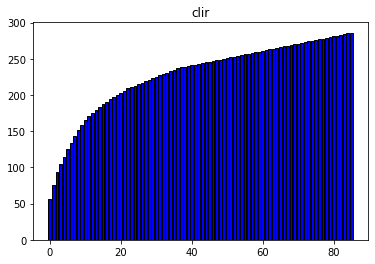

125


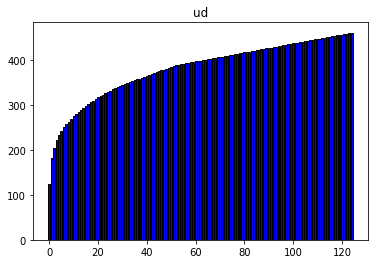

37


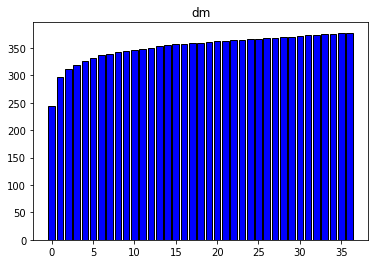

50


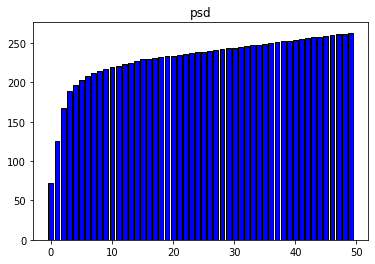

In [111]:
# Present commulative frequency of path-patterns histogram
domain = ['device', 'restaurants', 'laptops'][2]
# formalism = ["ud", "dm", "psd"][2]
for formalism in formalisms:
    print(len(deplbl_counters[formalism][domain]))
    # plot_bar_with_long_labels(*zip(*deplbl_top10[formalism][domain]), title=formalism)
    data = sorted(deplbl_counters[formalism][domain].values(), reverse=True)
    cum = np.cumsum(data)
    _, ax = plt.subplots()
    ax.bar(np.arange(len(cum)), cum, color = 'blue', edgecolor = 'black')
    ax.set_title(formalism)
    plt.show()

### Path Pattern - Cross-domain Similarity

We want to assess to what extent linguistic information (syntactic vs. semantic information) may facilitate cross-domain generalization w.r.t. the ABSA task. To that end, we will measure how similar are OT\~~AT paths across different domains.

For each formalism, a domain is represented by a probability distribution of path-patterns. We measure the Jensen–Shannon Divergence (JSD) between any two domains, where lower JSD signals a potential for better cross-domain transfer.  

In [112]:
import scipy
from scipy.spatial.distance import jensenshannon as jsd
from itertools import combinations

# convert path-pattern raw data (deplbl_pattern_strs) to a probability distribtuion of patterns
all_patterns_of_formalism = {formalism: list(set().union(*[deplbl_pattern_strs[formalism][domain] 
                                                           for domain in domains])) 
                             for formalism in formalisms}
n_all_patterns = {formalism: len(all_patterns) for formalism, all_patterns in all_patterns_of_formalism.items()}
print("total number of patterns across domains: ", 
      n_all_patterns)
# probabilty distribution for a domain would be a list, where index i is 
# the probability of the pattern all_patterns_of_formalism[formalism][i]
pattern2idx = {formalism: {pattern: idx
                           for idx, pattern in enumerate(all_patterns_of_formalism[formalism])}
               for formalism in formalisms}
pattern_prob_distr =  {formalism: {domain: [deplbl_counters[formalism][domain][pattern] / count_is_directed_path[formalism][domain] 
                                            for pattern in all_patterns_of_formalism[formalism]] 
                                   for domain in domains} 
                       for formalism in formalisms}
assert abs(1-sum(pattern_prob_distr['dm']['device']))<0.00000001, "probability distribution should sum up to 1"

# compute Jensen–Shannon Divergence (JSD) between any two domains
domain_pairs = list(combinations(domains, 2))
jsds = {formalism: {f"{dom1}-{dom2}": jsd(pattern_prob_distr[formalism][dom1], pattern_prob_distr[formalism][dom2], base=2) 
                    for dom1, dom2 in domain_pairs}
        for formalism in formalisms}
display_ndict(jsds)

total number of patterns across domains:  {'clir': 167, 'ud': 221, 'dm': 68, 'psd': 100}


-,device-restaurants,device-laptops,restaurants-laptops,mean
clir,0.44694165044082634,0.5289337146373878,0.5627120372025615,0.5128624674269252
ud,0.3867909180946283,0.47995387729075345,0.48366024647008926,0.45013501395182365
dm,0.20629419865364523,0.2884745618354457,0.2734461836310043,0.25607164804003174
psd,0.34666981158496674,0.41488716420088073,0.47360542934857325,0.41172080171147357


#### DRAFT

In [113]:
## work-space
g = all_indicative_graphs["dm"]["laptops"][4]
nxg = to_nx(g)
print(directed_path_length(nxg))
# print([n.label for n in nxg.g.nodes])
print(nxg.input)
print(nxg.g.opinion_spans)
print(nxg.g.aspect_spans)

c= Counter([1,2,3,1,2,3,1,1,1,5,4,2,12])


1
- No backlit keyboard , but not an issue for me .
[(1, 2)]
[(3, 4)]
